# EUR Predictor

Directory contains minute by minute prices of EUR/USD for the past 10 years (with the exception of 2014).  

This Notebook will build a RNN Model to predict the movement of the EUR prices based of historical minute by minute data.

Training and testing is easily separated by picking a year for training and another year for testing.  This, however, is not a great practice as training and testing sets are not equaly and randomly represented.  You will need to change the code to get better representation of training and testing.

For the purposes of playing around, you can play with Hyperparameters to design your model.



### Import the  libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


### Defining Hyperparameters

In [3]:
# Define the sequence of minutes you want to train on 
SEQUENCE_TIMEPOINTS = 20  # 5-50   

# Define how many LSTM Cells you need to have per each Layer
LSTM_UNITS = 40 

# Single Layer will be an LSTM Layer, combined with Dropout layer
# Define how many of these you want to have stacked (minimum of 2 needed)
LSTM_LAYERS = 4
DROPOUT_RATE = 0.2

EPOCHS = 100
BATCH_SIZE = 32

OPTIMIZER = 'adam'
LOSS = 'mean_squared_error'

# Training and Testing
# Pick a year for Training and a year for Testing.  This is just a suggested easy way
# to demonstrate the process.  To build a better model, you will need to mix things around
# and randomly chose testing sequences (maybe with a mod function), this will be a better 
# sampling for both training and test data
TRAINING_YEAR='2017'
TESTING_YEAR='2018'

### Load the data

Data is orgainized in csv files marked by a year, containing minute by minute price information

In [4]:
dataset_train = pd.read_csv(TRAINING_YEAR+'.csv')

# Restrict the dataset to either:  just prices
training_set = dataset_train.iloc[:,2:3]

# or Date, time, and pricess, if you want to train on all 3
#   this is if you want to derive some good info from the date/time like:
#    month of the year, time of day, day in the week, weekend or not, etc
# training_set = dataset_train.iloc[:,2:3]


In [5]:
training_set

,OpenBid
0,1.05155
1,1.05209
2,1.05177
3,1.05188
4,1.05196
5,1.05196
6,1.05205
7,1.05210
8,1.05208
9,1.05208


### Feature scaling

Best thing is to scale the prices from 0 to 1

In [6]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
training_set_scaled =sc.fit_transform(training_set)

In [7]:
training_set_scaled 

array([[0.09803585],
       [0.1011281 ],
       [0.09929565],
       ...,
       [0.9463437 ],
       [0.94863426],
       [0.94708813]])

### Creating a data structure for training

Each data point will have previous number of points for RNN training

In [8]:
X_train = []
y_train = []
for i in range(SEQUENCE_TIMEPOINTS, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-SEQUENCE_TIMEPOINTS:i,0])
    y_train.append(training_set_scaled[i,0])
X_train = np.array(X_train)
y_train = np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

### Build the RNN

In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout


Using TensorFlow backend.


In [10]:
regressor = Sequential()

# Layer 1
regressor.add(LSTM(units=LSTM_UNITS, return_sequences=True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(DROPOUT_RATE))

# Layer 2 to n-1
for i in range(LSTM_LAYERS-2):
    regressor.add(LSTM(units=LSTM_UNITS, return_sequences=True))
    regressor.add(Dropout(DROPOUT_RATE))

# Last LSTM Layer
regressor.add(LSTM(units=LSTM_UNITS))
regressor.add(Dropout(DROPOUT_RATE))

# Last layer to predict -  Only one Item to predict - EURO price at time
regressor.add(Dense(units = 1))

#### Show what model looks like

In [11]:
regressor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20, 40)            6720      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 20, 40)            12960     
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 20, 40)            12960     
_________________________________________________________________
dropout_3 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 40)                12960     
__________

#### Set some hyperparameters and train 

In [12]:
regressor.compile(optimizer=OPTIMIZER,  loss=LOSS)
regressor.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/100
371615/371615 [==============================] - 437s 1ms/step - loss: 0.0014
Epoch 2/100
371615/371615 [==============================] - 495s 1ms/step - loss: 6.7925e-04
Epoch 3/100
371615/371615 [==============================] - 509s 1ms/step - loss: 6.4911e-04
Epoch 4/100
371615/371615 [==============================] - 486s 1ms/step - loss: 6.3022e-04
Epoch 5/100
371615/371615 [==============================] - 471s 1ms/step - loss: 6.1978e-04
Epoch 6/100
371615/371615 [==============================] - 466s 1ms/step - loss: 6.1445e-04
Epoch 7/100
371615/371615 [==============================] - 466s 1ms/step - loss: 6.1018e-04
Epoch 8/100
371615/371615 [==============================] - 462s 1ms/step - loss: 6.0197e-04
Epoch 9/100
371615/371615 [==============================] - 464s 1ms/step - loss: 5.9940e-04
Epoch 10/100
371615/371615 [==============================] - 461s 1ms/step - loss: 5.9685e-04
Epoch 11/100
371615/371615 [==============================] - 4

371615/371615 [==============================] - 429s 1ms/step - loss: 5.6131e-04
Epoch 88/100
371615/371615 [==============================] - 428s 1ms/step - loss: 5.6269e-04
Epoch 89/100
371615/371615 [==============================] - 428s 1ms/step - loss: 5.5871e-04
Epoch 90/100
371615/371615 [==============================] - 427s 1ms/step - loss: 5.6099e-04
Epoch 91/100
371615/371615 [==============================] - 428s 1ms/step - loss: 5.6096e-04
Epoch 92/100
371615/371615 [==============================] - 428s 1ms/step - loss: 5.5995e-04
Epoch 93/100
371615/371615 [==============================] - 430s 1ms/step - loss: 5.5882e-04
Epoch 94/100
371615/371615 [==============================] - 462s 1ms/step - loss: 5.5860e-04
Epoch 95/100
371615/371615 [==============================] - 431s 1ms/step - loss: 5.6048e-04
Epoch 96/100
371615/371615 [==============================] - 430s 1ms/step - loss: 5.5698e-04
Epoch 97/100
371615/371615 [==============================] - 4

### Trying to setup testing on my own

In [13]:
dataset_test = pd.read_csv(TESTING_YEAR+'.csv')

# Restrict the dataset to either:  just prices
testing_set = dataset_test.iloc[:,2:3]
real_eur_price = testing_set.values

In [14]:
real_eur_price

array([[1.20037],
       [1.20083],
       [1.20035],
       ...,
       [1.14642],
       [1.14645],
       [1.14671]])

#### Load the real fx data for the  testing set

Save for later
dataset_total = pd.concat( (dataset_train['OpenBid'],dataset_test['OpenBid']), axis=0)
inputs = dataset_test[len(dataset_test)-SEQUENCE_TIMEPOINTS-60: ]

#### Second: Scale and predict the data

In [15]:
inputs = testing_set.values
inputs = inputs.reshape(-1,1)
inputs_backup=inputs.copy()    # Keep the unscalled version 

inputs = sc.transform(inputs)

In [16]:
len(inputs)

372607

In [17]:
X_test = []
real_eur = []
for i in range(SEQUENCE_TIMEPOINTS+1, len(inputs)-1):
    X_test.append(inputs[i-SEQUENCE_TIMEPOINTS:i, 0])
    real_eur.append(inputs_backup[i,0])
    

X_test = np.array(X_test)

#X_test


In [18]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [19]:
predicted_eur = regressor.predict(X_test)
# descale
predicted_eur = sc.inverse_transform(predicted_eur)



####  Visualize results

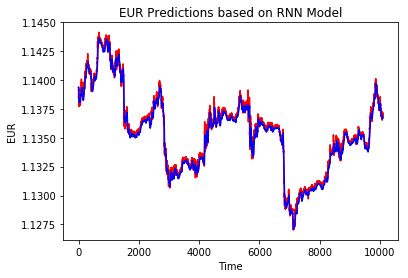

In [20]:
plt.plot(real_eur[350000:360100], color='red', label='Real EUR')
plt.plot(predicted_eur[350000:360100], color='blue', label='Predicted EUR')
plt.title("EUR Predictions based on RNN Model")
plt.xlabel("Time")
plt.ylabel("EUR")
plt.show()

#### Calculate ups and downs to previous minute

In [21]:

count_guess_correct_up=0
count_guess_correct_down=0
count_guess_incorrect_up=0
count_guess_incorrect_down=0
count_neither=0
for i in range(300000,len(real_eur)):
    deltaReal=real_eur[i]-real_eur[i-1]
    deltaPredict=predicted_eur[i]-predicted_eur[i-1]
    if deltaReal>0 and deltaPredict>0:
        count_guess_correct_up+=1
    elif deltaReal>0 and deltaPredict<0:
        count_guess_incorrect_up+=1
    elif deltaReal<0 and deltaPredict<0:
        count_guess_correct_down+=1
    elif deltaReal<0 and deltaPredict>0:
        count_guess_incorrect_down+=1
    else:
        count_neither+=1

print('count_guess_correct_up:     ',count_guess_correct_up)
print('count_guess_correct_down:   ',count_guess_correct_down)
print('count_correct total:        ',count_guess_correct_up+count_guess_correct_down)
print()
print('count_guess_incorrect_up:   ',count_guess_incorrect_up)
print('count_guess_incorrect_down: ',count_guess_incorrect_down)
print('count_incorrect total:      ',count_guess_incorrect_up+count_guess_incorrect_down)

print('count_neither:              ',count_neither)
        
    
    

count_guess_correct_up:      16673
count_guess_correct_down:    16122
count_correct total:         32795

count_guess_incorrect_up:    17439
count_guess_incorrect_down:  17391
count_incorrect total:       34830
count_neither:               4960
